In [0]:
%pip install tensorflow==2.1.0

In [0]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import tensorflow_addons as tfa

import os
import numpy as np
import matplotlib.pyplot as plt

Getting Dataset


In [0]:
_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
path_to_zip = tf.keras.utils.get_file('tiny-imagenet-200.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'tiny-imagenet-200')


In [0]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

Parameters


In [0]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
total_epochs = 50
batch_size = 400
input_shape = (64, 64, 3)
num_classes = 200

Utilities

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
def model_callbacks(name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(name, monitor = 'val_categorical_accuracy',
                                mode = 'max', save_best_only = True, verbose = 1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor = 0.1,    
                                  patience = 5, verbose = 1)
    return [reduce_lr]

In [0]:
def plot_graph(model, N):
    
    plt.figure(0)
    plt.plot(np.arange(0, N), model.history['loss'], label='Training loss')
    plt.plot(np.arange(0, N), model.history['val_loss'], label='Testing loss')
    plt.title('Training vs Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(1)
    plt.plot(np.arange(0, N), model.history['categorical_accuracy'], label='Top 1 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_categorical_accuracy'], label='Top 1 Testing Accuracy')
    plt.title('Top 1 Training vs Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.figure(2)
    plt.plot(np.arange(0, N), model.history['top_k_categorical_accuracy'], label='Top 5 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_top_k_categorical_accuracy'], label='Top 5 Testing Accuracy')
    plt.title('Top 5 Training vs Testing Acuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

Augmentation

In [0]:
augment = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zca_whitening=True,
                               validation_split = 0.1)

# horizontal_flip=True,
# preprocessing_function=func_PCA,
# brightness_range=(0.3, 0.7),
# shear_range=0.35,
# zoom_range=[0.5, 1.5],
# channel_shift_range=150.0,
# rescale=1./255,
# width_shift_range=0.2, 
# height_shift_range=0.2,
# fill_mode='nearest',

In [0]:
augment.mean = 112.69858580973307
augment.std = 70.93752549462194
augment.principal_components = 20

In [0]:
train_data_gen = augment.flow_from_directory(batch_size=batch_size, directory=train_dir,
                                             shuffle=True, target_size=(64, 64),
                                             class_mode='categorical', subset='training')

val_data_gen = augment.flow_from_directory(batch_size=batch_size, directory = train_dir,
                                                         shuffle=True, target_size=(64, 64),
                                                         class_mode='categorical', subset = 'validation')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


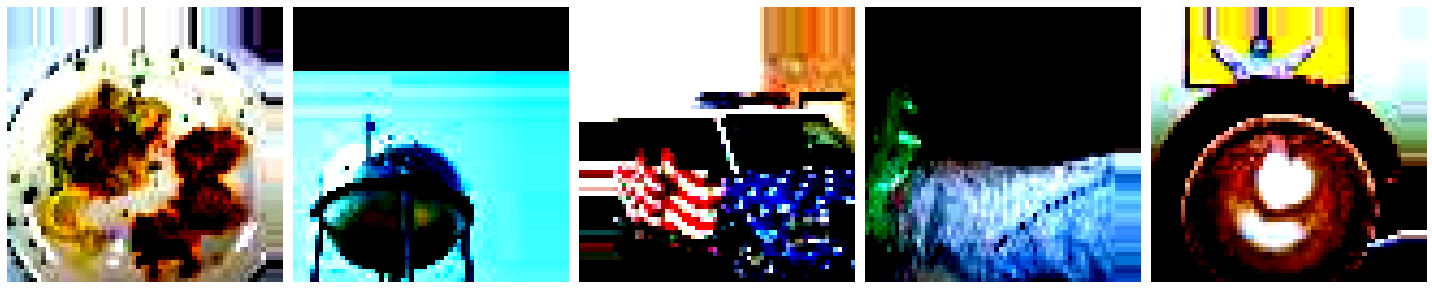

In [0]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

Model

In [0]:
# def build(input_shape, num_classes):
#     model = tf.keras.Sequential()

#     #conv-spatial batch norm - relu #1 
#     model.add(tf.keras.layers.ZeroPadding2D((2,2),input_shape=(64,64,3)))
#     model.add(tf.keras.layers.Convolution2D(64,(5,5),strides=(2,2),kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-7,l2=1e-7)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 

#     #conv-spatial batch norm - relu #2
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(64,(3,3),strides=(1,1)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 

#     #conv-spatial batch norm - relu #3
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(128,(3,3),strides=(2,2)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 
#     model.add(tf.keras.layers.Dropout(0.25)) 

#     #conv-spatial batch norm - relu #4
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(128,(3,3),strides=(1,1)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 

#     #conv-spatial batch norm - relu #5
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(256,(3,3),strides=(2,2)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 

#     #conv-spatial batch norm - relu #6
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(256,(3,3),strides=(1,1)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 
#     model.add(tf.keras.layers.Dropout(0.25))

#     #conv-spatial batch norm - relu #7
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(512,(3,3),strides=(2,2)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 

#     #conv-spatial batch norm - relu #8
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(512,(3,3),strides=(1,1)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 
    
#     #conv-spatial batch norm - relu #9
#     model.add(tf.keras.layers.ZeroPadding2D((1,1)))
#     model.add(tf.keras.layers.Convolution2D(1024,(3,3),strides=(2,2)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu'))
#     model.add(tf.keras.layers.Dropout(0.25)) 

#     #Affine-spatial batch norm -relu #10 
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-5)))
#     model.add(tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
#     model.add(tf.keras.layers.Activation('relu')) 
#     model.add(tf.keras.layers.Dropout(0.5)) 

#     model.add(tf.keras.layers.Dense(num_classes,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-5)))

#     model.summary()

#     return model

In [0]:
def build(input_shape, num_classes):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Convolution2D(96, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    model.add(tf.keras.layers.Convolution2D(256, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    model.add(tf.keras.layers.Convolution2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    
    model.add(tf.keras.layers.Convolution2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model

Training

In [0]:
# Training TinyNet
model_tinynet = build(input_shape, num_classes)
model_tinynet.compile(optimizer=tfa.optimizers.weight_decay_optimizers.SGDW(
                        learning_rate=learning_rate, momentum=momentum, 
                        weight_decay=weight_decay, nesterov=True, name='SGDW'),
                        loss='categorical_crossentropy', 
                        metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

history = model_tinynet.fit(train_data_gen, epochs = total_epochs,
                            validation_data=val_data_gen, verbose=1)

# plotting
plot_graph(history, total_epochs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 96)        34944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 384)        

KeyboardInterrupt: ignored

Learning Rate / Batch Size + Layers + Training Samples Count + Different Augmentations + Optimizer Paramenters